In [1]:
from planning_through_contact.geometry.planar.planar_pushing_trajectory import PlanarPushingContactMode, PlanarPushingTrajectory
from planning_through_contact.simulation.controllers.hybrid_mpc import HybridMpcConfig
from planning_through_contact.simulation.dynamics.slider_pusher.slider_pusher_system import SliderPusherSystem
import numpy as np
import matplotlib.pyplot as plt

traj = PlanarPushingTrajectory.load("../../trajectories/box_pushing_demos/hw_demo_C_1.pkl")
for idx, seg in enumerate(traj.traj_segments):
        if seg.mode != PlanarPushingContactMode.NO_CONTACT:
            first_contact_seg = seg
            first_contact_seg_idx = idx
            print(f"First contact segment: {first_contact_seg.mode}, idx {first_contact_seg_idx}")
            break
sys = SliderPusherSystem(
        contact_location=first_contact_seg.mode.to_contact_location(),
        config=traj.config.dynamics_config,
    )
mpc_config = HybridMpcConfig(
    step_size=0.03,
    horizon=35,
    num_sliding_steps=1,
    rate_Hz=50,
    Q=np.diag([3, 3, 0.01, 0]) * 100,
    Q_N=np.diag([3, 3, 1, 0]) * 2000,
    R=np.diag([1, 1, 0]) * 0.5,
)


First contact segment: PlanarPushingContactMode.FACE_1, idx 4


In [2]:
# Arrays to store the graph values
start_time = first_contact_seg.start_time
end_time = first_contact_seg.end_time
num_steps = 10000
times, step = np.linspace(start_time, end_time, num_steps, endpoint=False, retstep=True)
pusher_pos_list= []
pusher_pos_pred_list = []

for t in times:

    state_1 = traj.get_value(t, 'state')
    control_1 = traj.get_value(t, 'control')
    desired_vel_1 = sys.get_pusher_velocity(state_1, control_1).flatten()
    pusher_pos = traj.get_pusher_planar_pose(t).pos().flatten()
    if t == start_time:
        pusher_pos_pred = pusher_pos
    else:
        pusher_pos_pred = pusher_pos_pred_list[-1] + desired_vel_1 * step

    # Storing the values
    pusher_pos_list.append(pusher_pos)
    pusher_pos_pred_list.append(pusher_pos_pred)

# Convert lists to numpy arrays for easy plotting
pusher_pos_pred_list = np.array(pusher_pos_pred_list)
pusher_pos_list = np.array(pusher_pos_list)


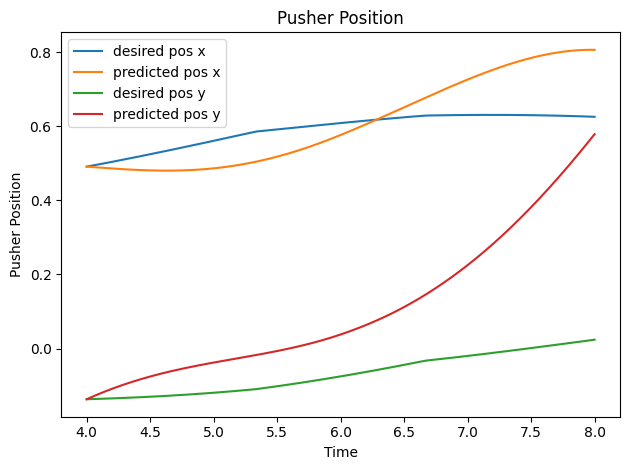

In [3]:
pos_labels = ['x', 'y']
for i in range(2):
    plt.plot(times, pusher_pos_list[:, i], label=f"desired pos {pos_labels[i]}")
    plt.plot(times, pusher_pos_pred_list[:, i], label=f"predicted pos {pos_labels[i]}")

plt.title(f"Pusher Position")
plt.xlabel('Time')
plt.ylabel(f'Pusher Position')
plt.legend()

plt.tight_layout()
plt.show()